In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import tqdm_notebook, tnrange
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate,add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array,load_img,array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob

In [2]:
im_height = 512
im_width = 512
im_std_height = 128
im_std_width = 128

In [3]:
def count_img(root, total, folders, total_count, text):
    for filename in tqdm(os.listdir(root)):
        if filename != ".DS_Store":
            folders.append(filename)
            ids = next(os.walk(root+'/'+filename))[2]# list of names all images in the given path
            total_count.append(len(ids))
            total +=len(ids)
    print(text)
    print("Number of images and masks = ", total)
    print("The folders containing images and masks are :", folders)
    print("Image tally accordingly :", total_count)
    return total, folders, total_count

In [4]:
def mac_equalizer(total_count):
    for i in range(len(total_count)):
        if total_count[i] % 2 != 0 :
            total_count[i] -= 1
    print("New count is :", total_count)
    print("New total = ", sum(total_count))
    return total_count,sum(total_count)

In [5]:
def upload(root, folders, X, y, text, im_height, im_width):
    count_img = 0
    count_mask = 0
    
    print(text)
    
    for file in folders : 
        image_dir_path = root+ "/" +file
        mask_dir_path =  root+ "/" +file
        
        for img_path in tqdm(sorted(glob.glob(os.path.join(image_dir_path, "*_img.png")))):
            img = load_img(img_path, color_mode = "grayscale")
            img = img_to_array(img)
            img = resize(img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
            img = img/255.0
            X[count_img]=img 
            count_img+=1
        print("Image upload count = ", count_img)
        
        
        for mask_path in tqdm(sorted(glob.glob(os.path.join(mask_dir_path, "*_mask.png")))):
            mask = load_img(mask_path, color_mode = "grayscale")
            mask = img_to_array(mask)
            mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
            mask = mask/255.0
            y[count_mask]=mask
            count_mask+=1
        print("Mask upload count = ", count_mask)
    return X,y

In [6]:
def input_matrix(train_total, test_total, im_height, im_width) :
    X = np.zeros((int(train_total/2), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((int(train_total/2), im_height, im_width, 1), dtype=np.float32)
    
    X_test = np.zeros((int(test_total/2), im_height, im_width, 1), dtype=np.float32)
    y_test = np.zeros((int(test_total/2), im_height, im_width, 1), dtype=np.float32)
    
    return X, y, X_test, y_test


In [7]:
def pre_visualize(X, y, text, ix = None) :
    
    print(text)
    for i in range(5) : 
        if ix == None :
            ix = random.randint(0, len(X)-1)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
        ax1.imshow(X[ix], cmap = 'gray', interpolation = 'bilinear')
        ax1.set_title('Image')
        
        ax2.imshow(y[ix], cmap = 'gray', interpolation = 'bilinear')
        ax2.set_title('Mask')
        ix = None

In [8]:
train_text = "\t\t\t\t\t\tTraining "
valid_text = "\t\t\t\t\t\tValidation "
test_text = "\t\t\t\t\t\t\tTesting "
train_total = 0
test_total = 0
train_total_count = []
test_total_count = []
train_folders = []
test_folders = []
train_root = "compare/train"
test_root = "compare/test"


train_total, train_folders, train_total_count = count_img(train_root, train_total, train_folders, train_total_count, "Training")
test_total, test_folders, test_total_count = count_img(test_root, test_total, test_folders, test_total_count, "Testing")


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1756.41it/s]


Training
Number of images and masks =  199
The folders containing images and masks are : ['SS_EA031', 'SS_3']
Image tally accordingly : [157, 42]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3440.77it/s]

Testing
Number of images and masks =  21
The folders containing images and masks are : ['EA001_test', 'EA002_test']
Image tally accordingly : [10, 11]


In [9]:
train_total_count, train_total = mac_equalizer(train_total_count)
test_total_count, test_total = mac_equalizer(test_total_count)

New count is : [156, 42]
New total =  198
New count is : [10, 10]
New total =  20


In [10]:
#X, y, X_test, y_test = input_matrix(train_total, test_total, im_height, im_width) 
X_std, y_std, X_std_test, y_std_test = input_matrix(train_total, test_total, im_std_height, im_std_width) 

In [11]:
#X, y = upload(train_root, train_folders, X, y, train_text, im_height, im_width)

In [12]:
X_std, y_std = upload(train_root, train_folders, X_std, y_std, train_text, im_std_height, im_std_width)

						Training 


100%|███████████████████████████████████████████| 78/78 [00:01<00:00, 66.95it/s]


Image upload count =  78


100%|███████████████████████████████████████████| 78/78 [00:00<00:00, 82.57it/s]


Mask upload count =  78


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 56.20it/s]


Image upload count =  99


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 75.19it/s]

Mask upload count =  99


In [13]:
#X_test, y_test = upload(test_root, test_folders, X_test, y_test, test_text, im_height, im_width)

In [14]:
X_std_test, y_std_test = upload(test_root, test_folders, X_std_test, y_std_test, test_text, im_std_height, im_std_width)

							Testing 


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 62.94it/s]


Image upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 66.86it/s]


Mask upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 60.56it/s]


Image upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 75.79it/s]

Mask upload count =  10


In [15]:
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [18]:
#X_std_train, X_std_valid, y_std_train, y_std_valid = train_test_split(X_std, y_std, train_size = 0.8, random_state = 0)

						Training 


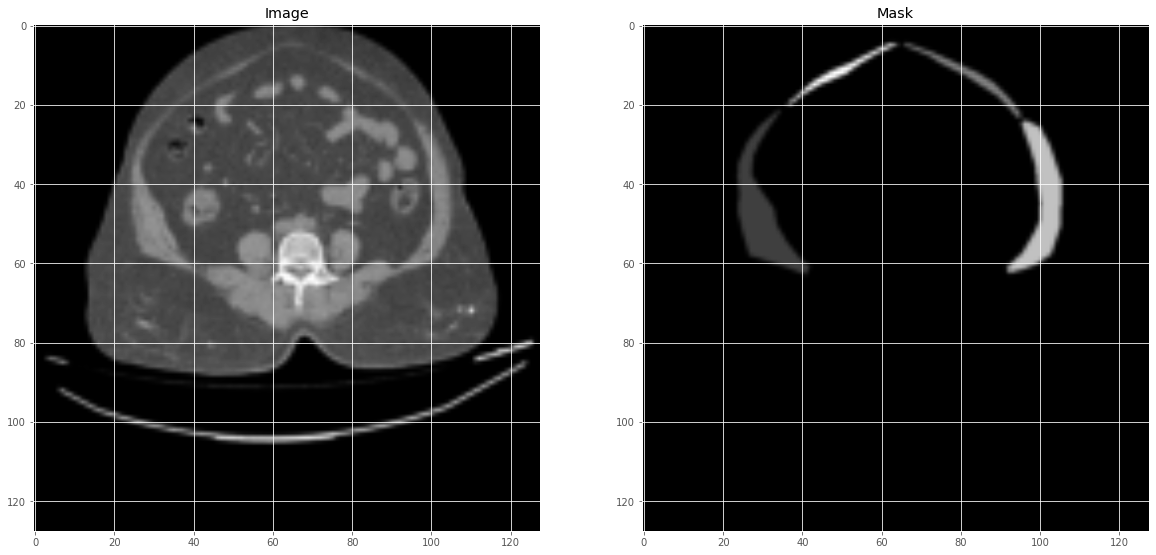

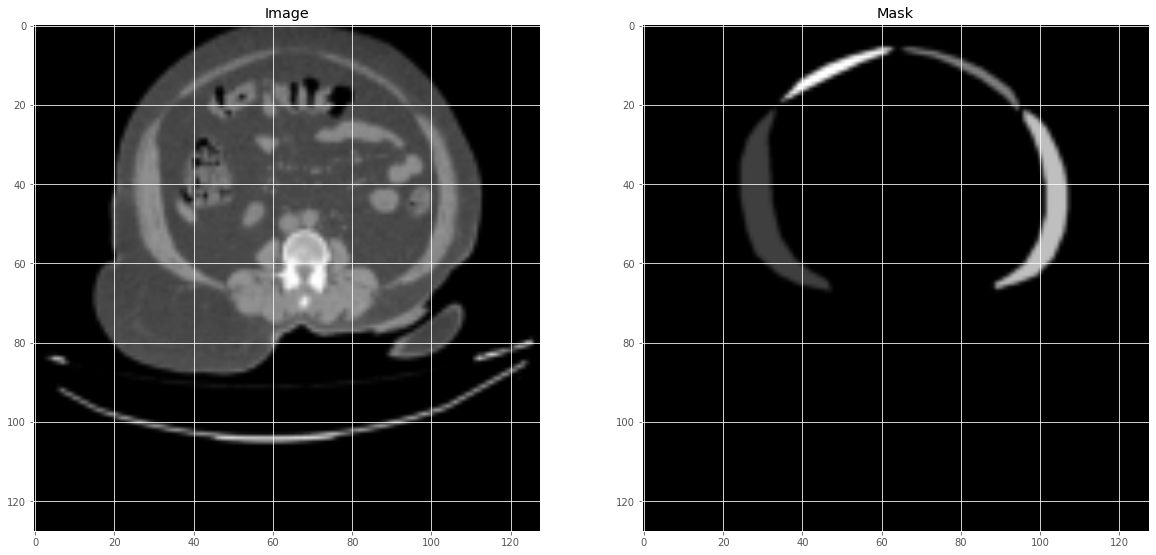

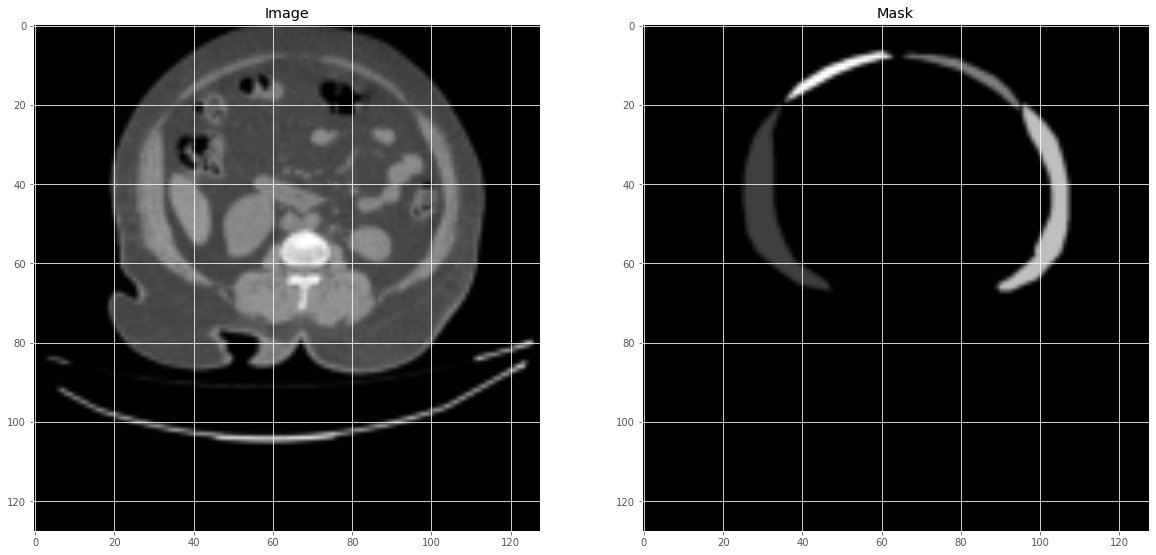

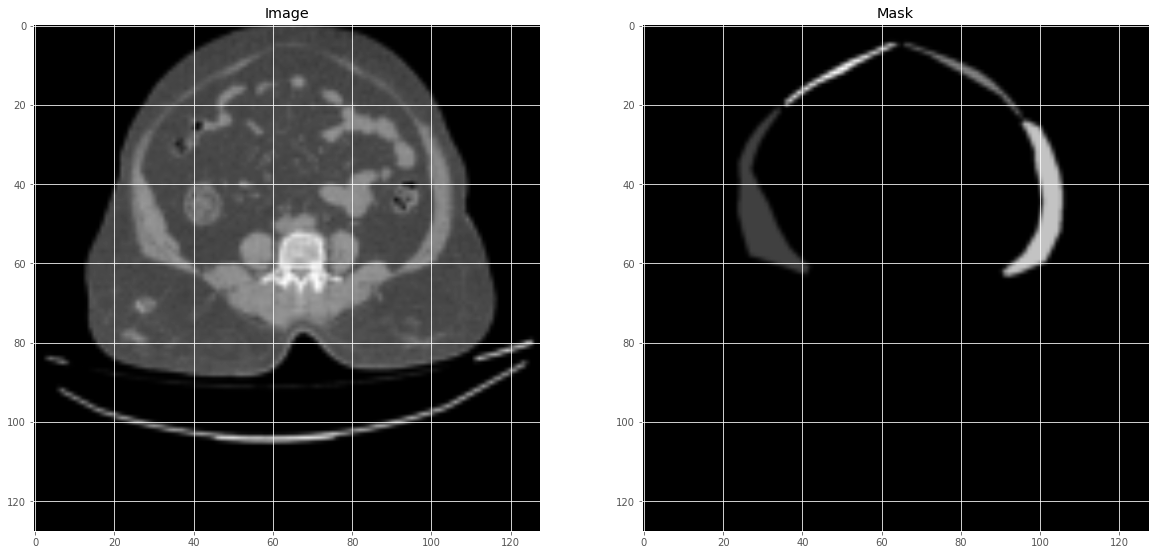

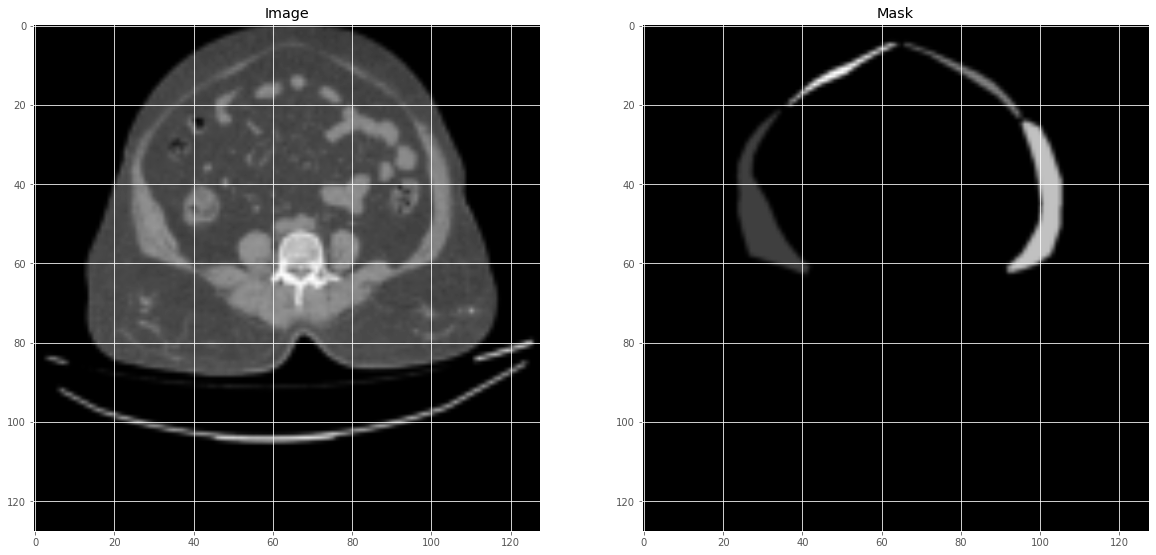

In [19]:
pre_visualize(X_std_train, y_std_train, train_text)

						Validation 


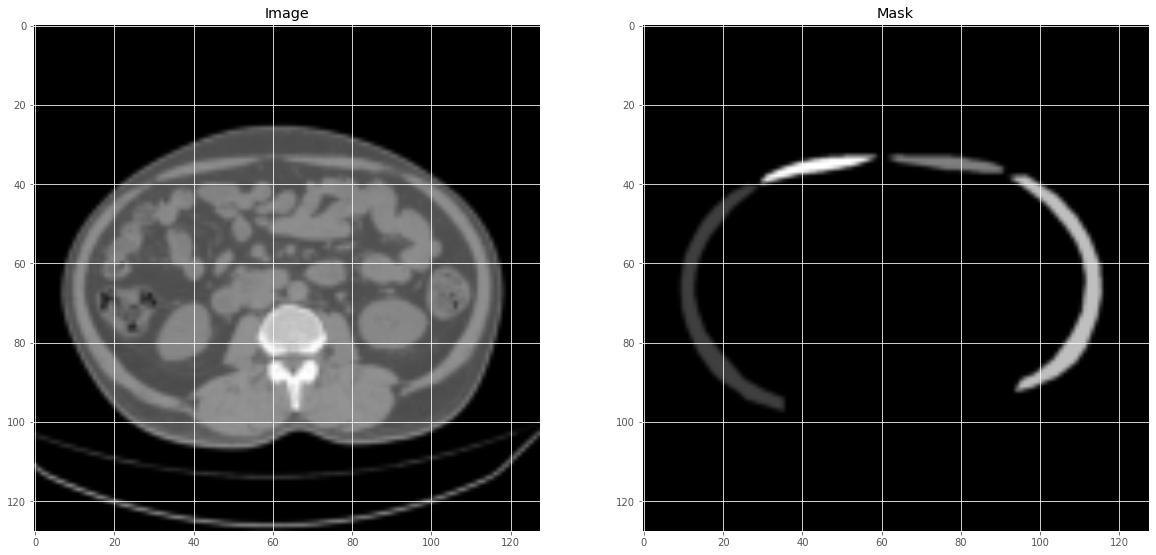

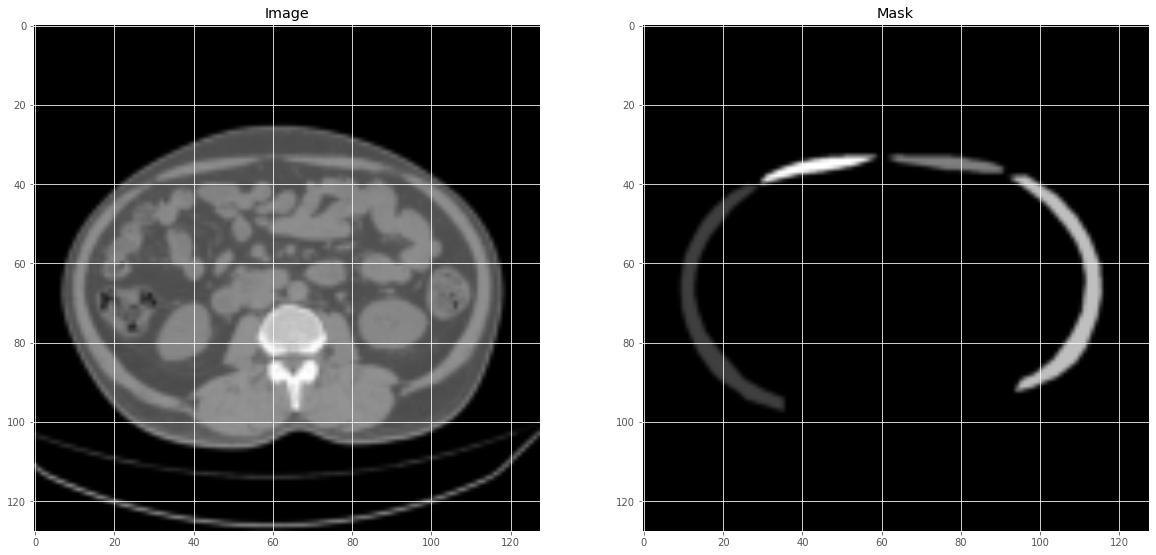

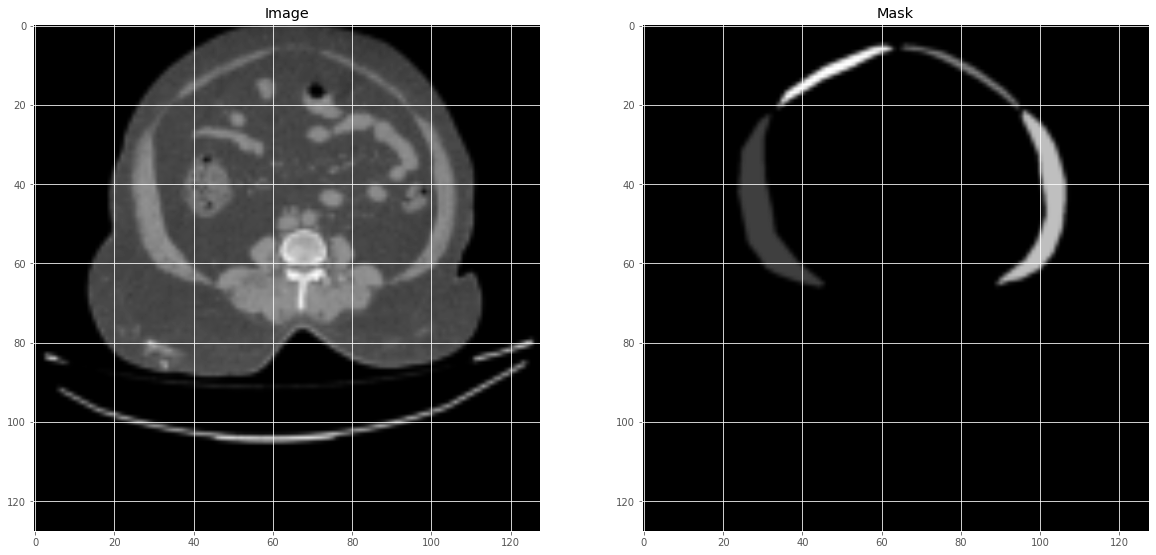

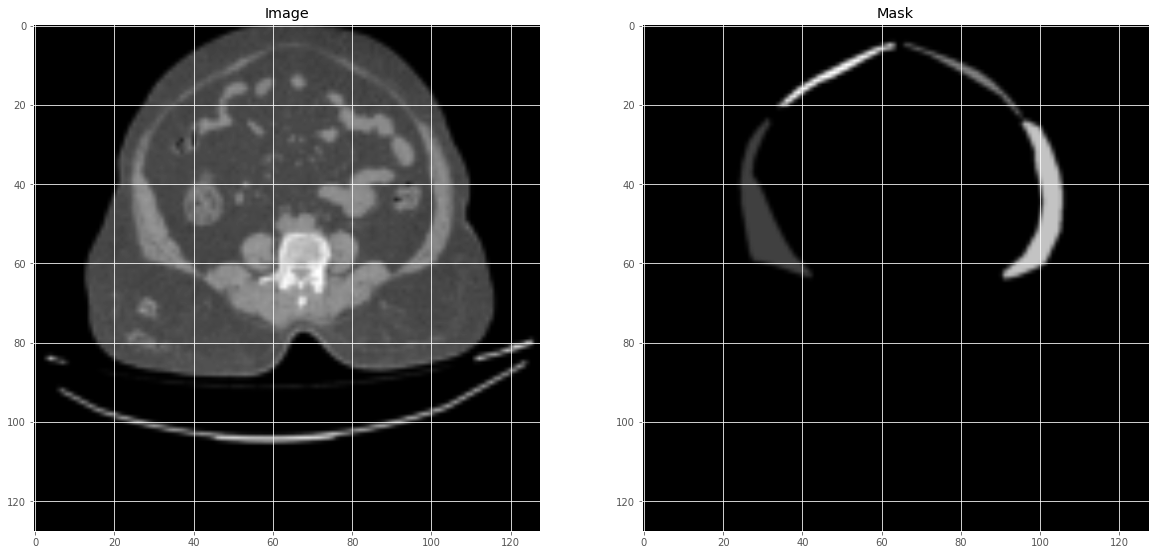

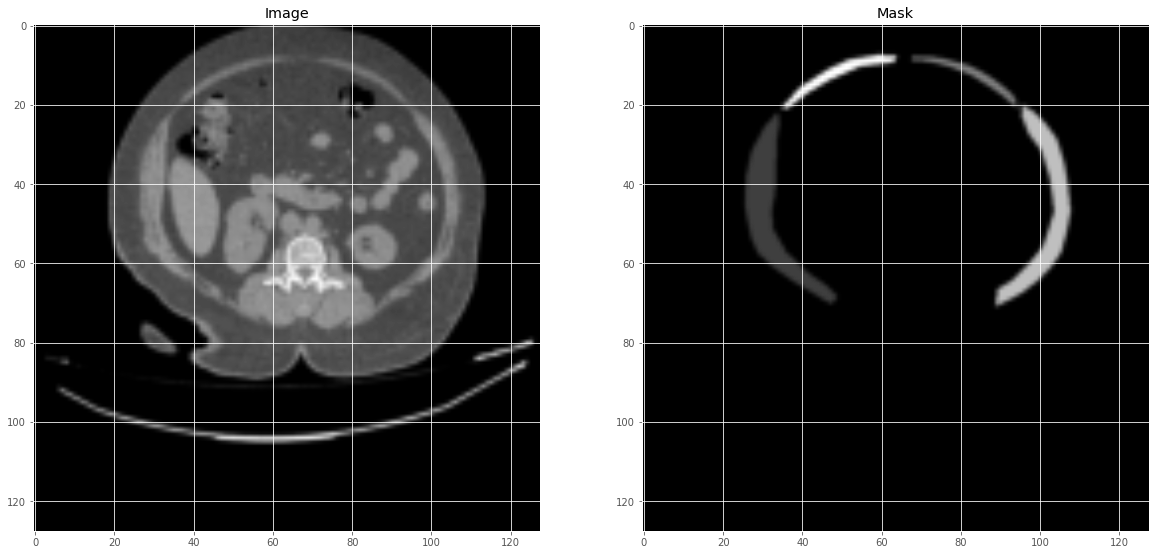

In [20]:
pre_visualize(X_std_valid, y_std_valid, valid_text)

							Testing 


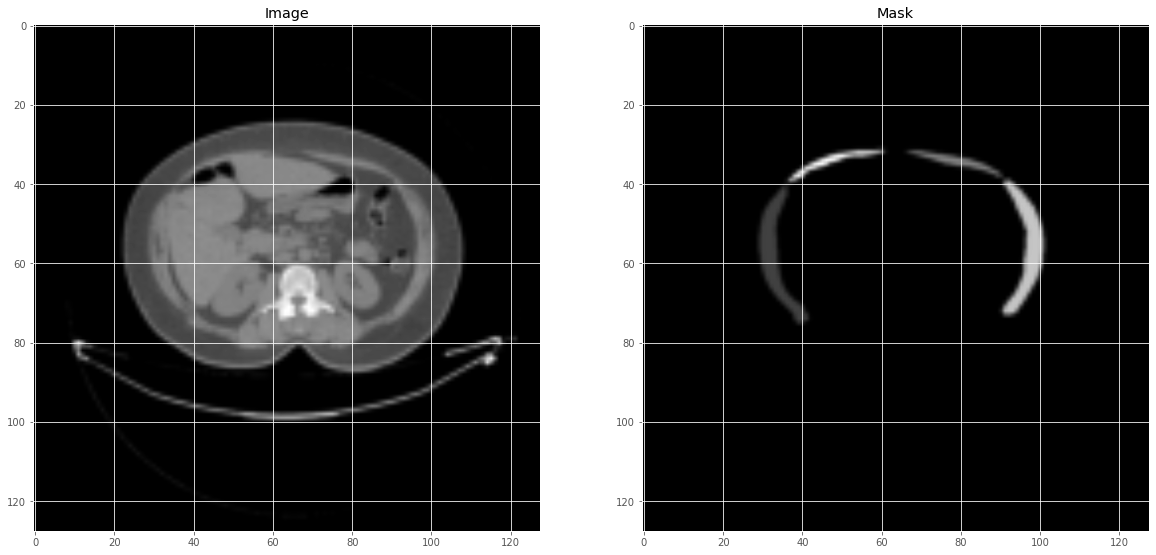

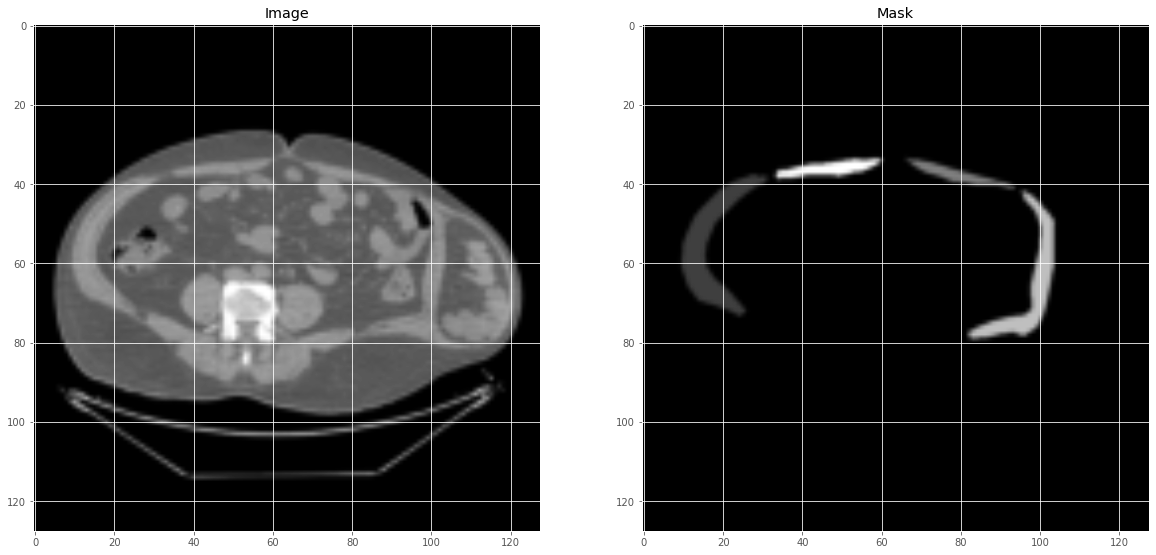

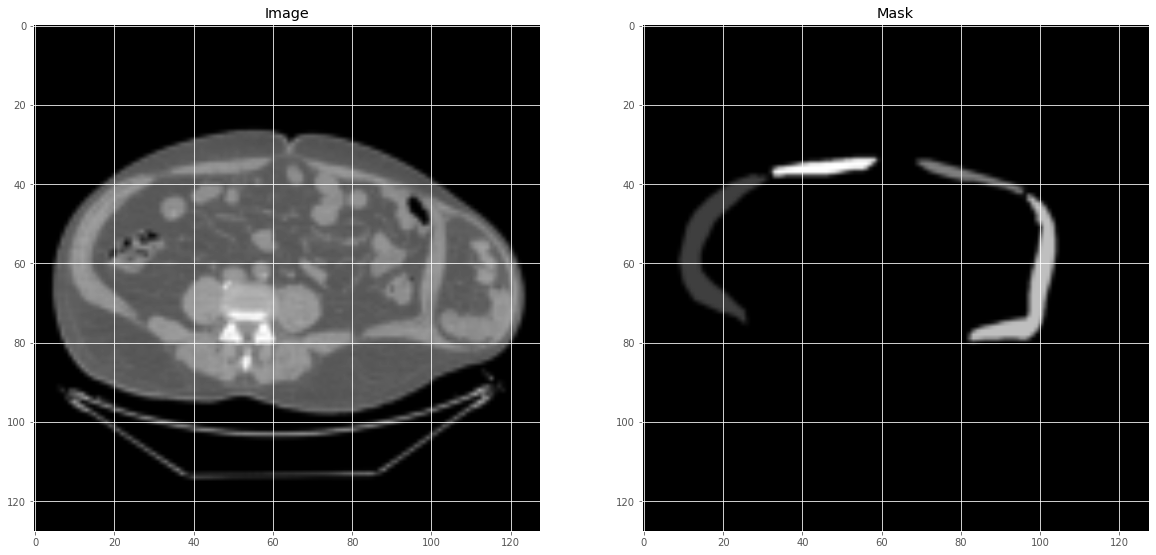

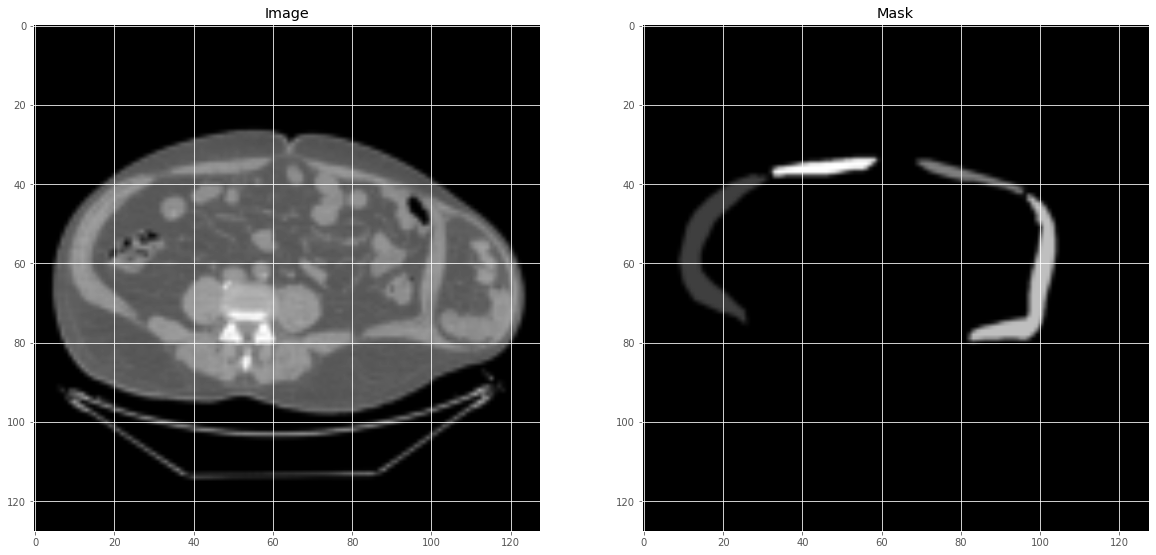

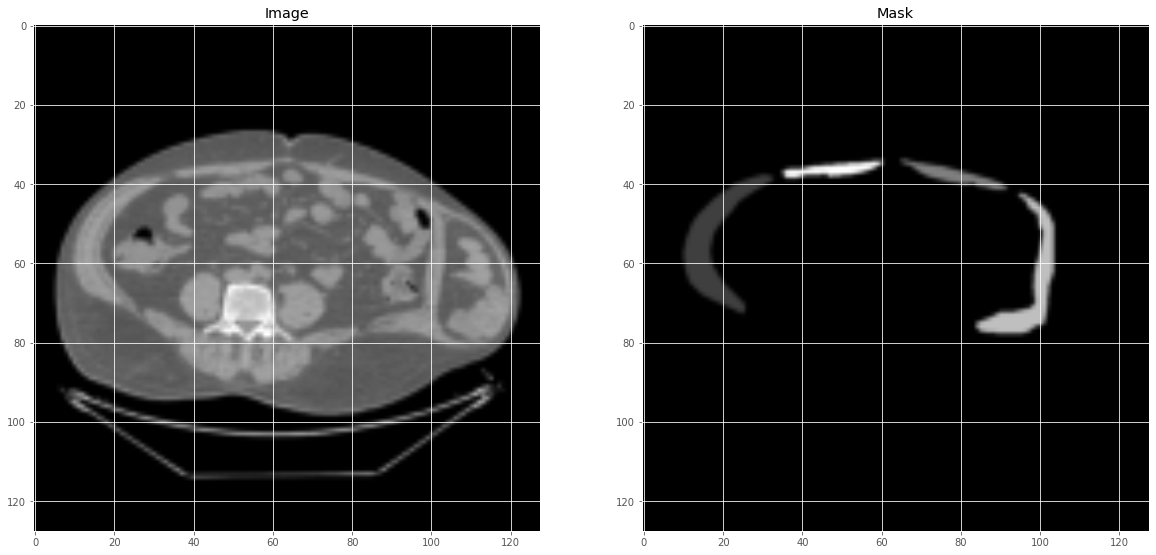

In [21]:
pre_visualize(X_std_test, y_std_test, test_text)

In [22]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [23]:
#UNet Architecture 
def get_std_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [26]:
from keras import backend as K


def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    val = (2. * intersection + K.epsilon()) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + K.epsilon())
    return 1. - val

In [27]:
from keras import backend as K
def iou_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    val = (intersection + K.epsilon()) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) - intersection + K.epsilon())
    return 1. - val

In [30]:
input_std_img = Input((im_std_height, im_std_width, 1), name='img')
model_std = get_std_unet(input_std_img, n_filters=16, dropout=0.05, batchnorm=True)
model_std.compile(optimizer=Adam(), loss=dice_loss, metrics=["accuracy"])

In [31]:
input_std_img = Input((im_std_height, im_std_width, 1), name='img')
model_std_DLE = get_std_unet(input_std_img, n_filters=16, dropout=0.1, batchnorm=True)
model_std_DLE.compile(optimizer=Adam(), loss=dice_loss, metrics=["accuracy"])

In [32]:
model_std.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [33]:
model_std_DLE.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 128, 128, 16  64         ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

In [35]:
# load the best model
model_std.load_weights('baselines/model_global_stdUNet-tgs-salt.h5')

In [36]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_std.evaluate(X_std_train, y_std_train, verbose=1)
model_std.evaluate(X_std_valid, y_std_valid, verbose=1)
model_std.evaluate(X_std_test, y_std_test, verbose=1)

1/1 [==============================] - 0s 128ms/step - loss: 0.2859 - accuracy: 0.9310


[0.2858734130859375, 0.930950939655304]

In [37]:
preds_train_global_std = model_std.predict(X_std_train, verbose=1)
preds_val_global_std = model_std.predict(X_std_valid, verbose=1)
preds_test_global_std = model_std.predict(X_std_test, verbose=1)

1/1 [==============================] - 0s 136ms/step


In [38]:
# load the best model
model_std.load_weights('baselines/model_local_stdUNet-tgs-salt.h5')

In [39]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_std.evaluate(X_std_train, y_std_train, verbose=1)
model_std.evaluate(X_std_valid, y_std_valid, verbose=1)
model_std.evaluate(X_std_test, y_std_test, verbose=1)

1/1 [==============================] - 0s 130ms/step - loss: 0.4158 - accuracy: 0.9313


[0.41581639647483826, 0.9312988519668579]

In [40]:
preds_train_local_std = model_std.predict(X_std_train, verbose=1)
preds_val_local_std = model_std.predict(X_std_valid, verbose=1)
preds_test_local_std = model_std.predict(X_std_test, verbose=1)

1/1 [==============================] - 0s 155ms/step


In [42]:
# load the best model
model_std_DLE.load_weights('baselines/model_local_stdUNet_DLE-tgs-salt.h5')

In [43]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_std_DLE.evaluate(X_std_train, y_std_train, verbose=1)
model_std_DLE.evaluate(X_std_valid, y_std_valid, verbose=1)
model_std_DLE.evaluate(X_std_test, y_std_test, verbose=1)

1/1 [==============================] - 0s 132ms/step - loss: 0.3630 - accuracy: 0.9297


[0.3629963994026184, 0.929656982421875]

In [44]:
preds_train_local_std_DLE = model_std_DLE.predict(X_std_train, verbose=1)
preds_val_local_std_DLE = model_std_DLE.predict(X_std_valid, verbose=1)
preds_test_local_std_DLE = model_std_DLE.predict(X_std_test, verbose=1)

1/1 [==============================] - 0s 163ms/step


In [45]:
range_1 = range(0,5) #35
#range_2 = range(24,29) #EA001
#range_3 = range(29,34) #EA002
range_4 = range(5,10) #76

In [55]:
#Function for viewing plots and predictions
def plot_sample_compare(X, y, preds_1, preds_2, preds_3, text, temp_range = range(0,5), ix=None):
    """Function to plot the results"""
    print(text) 
    
    for i in temp_range : 
        #if ix is None:
        ix = i
            
        fig, ax = plt.subplots(1, 5, figsize=(20, 10))
        ax[0].imshow(X[ix], cmap='gray')
        ax[0].set_title('Input')

        ax[1].imshow(y[ix].squeeze(),cmap='gray')
        ax[1].set_title('Mask')


        ax[2].imshow(preds_1[ix].squeeze(),cmap='gray')
        ax[2].set_title('Global Mask Predicted')
        
        ax[3].imshow(preds_2[ix].squeeze(),cmap='gray')
        ax[3].set_title('Local Mask Predicted')
        
        ax[4].imshow(preds_3[ix].squeeze(),cmap='gray')
        ax[4].set_title('Custom Local Mask Predicted')
        
   
        d1_loss = dice_loss(y[ix],preds_1[ix]).numpy()
        d1_loss = round(d1_loss*100, 3)
        
        d2_loss = dice_loss(y[ix],preds_2[ix]).numpy()
        d2_loss = round(d2_loss*100, 3)
        
        d3_loss = dice_loss(y[ix],preds_3[ix]).numpy()
        d3_loss = round(d3_loss*100, 3)
        
        i1_loss = iou_loss(y[ix],preds_1[ix]).numpy()
        i1_loss = round(i1_loss*100, 3)
        
        i2_loss = iou_loss(y[ix],preds_2[ix]).numpy()
        i2_loss = round(i2_loss*100, 3)
        
        i3_loss = iou_loss(y[ix],preds_3[ix]).numpy()
        i3_loss = round(i3_loss*100, 3)
        
        
        
        
        text_1 = "Dice loss of Std global image " + str(ix) +  " = " + str(d1_loss) + " %"
        text_3 = "Dice loss of Std local image " + str(ix) +  " = " + str(d2_loss) + " %"
        text_5 = "Dice loss of Custom Std Local image " + str(ix) +  " = " + str(d3_loss) + " %"
        
        text_2 = "IoU loss of Std global image " + str(ix) +  " = " + str(i1_loss) + " %"
        text_4 = "IoU loss of Std local image " + str(ix) +  " = " + str(i2_loss) + " %"
        text_6 = "IoU loss of Custom Std Local image " + str(ix) +  " = " + str(i3_loss) + " %"
        
        plt.figtext(0.4, 0.27, text_1, fontsize=18)
        plt.figtext(0.4, 0.24, text_3, fontsize=18)
        plt.figtext(0.4, 0.21, text_5, fontsize=18)
        plt.figtext(0.4, 0.15, text_2, fontsize=18)
        plt.figtext(0.4, 0.12, text_4, fontsize=18)
        plt.figtext(0.4, 0.09, text_6, fontsize=18)
        

						Training 


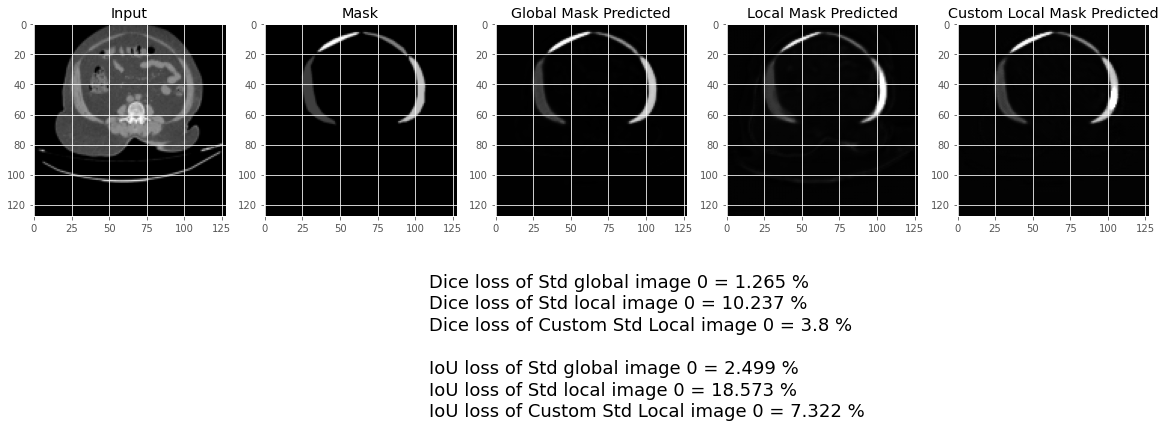

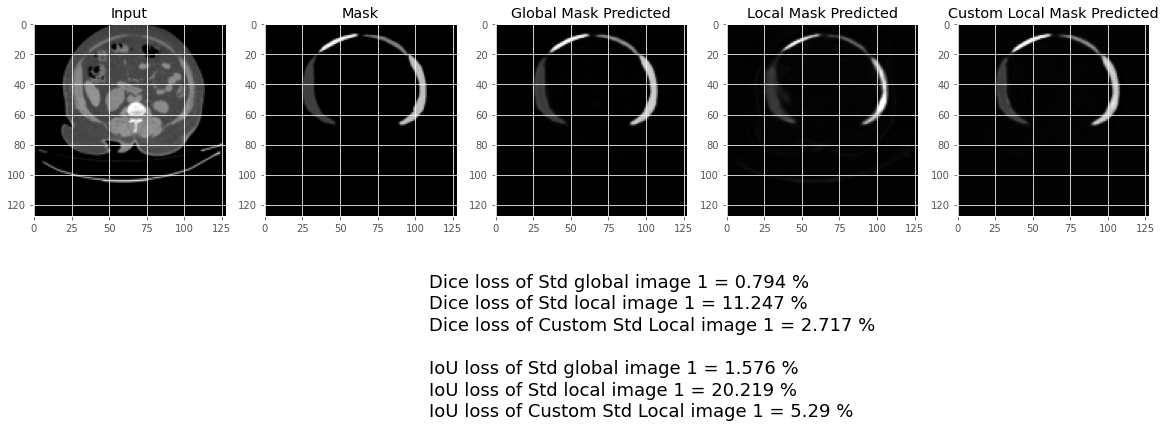

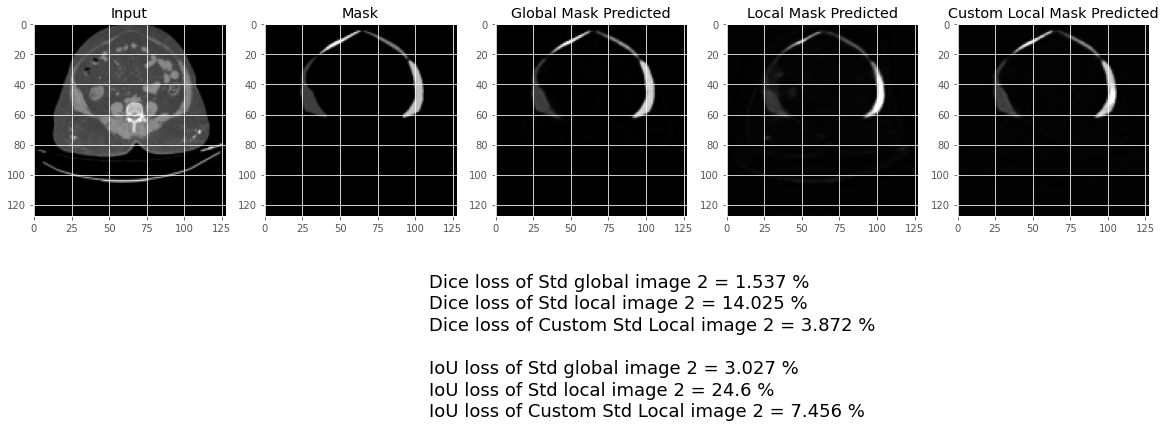

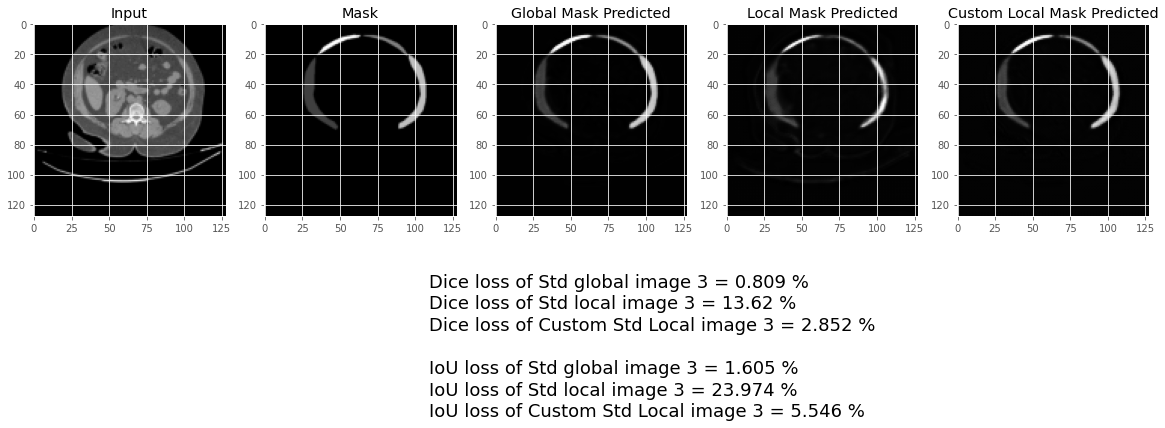

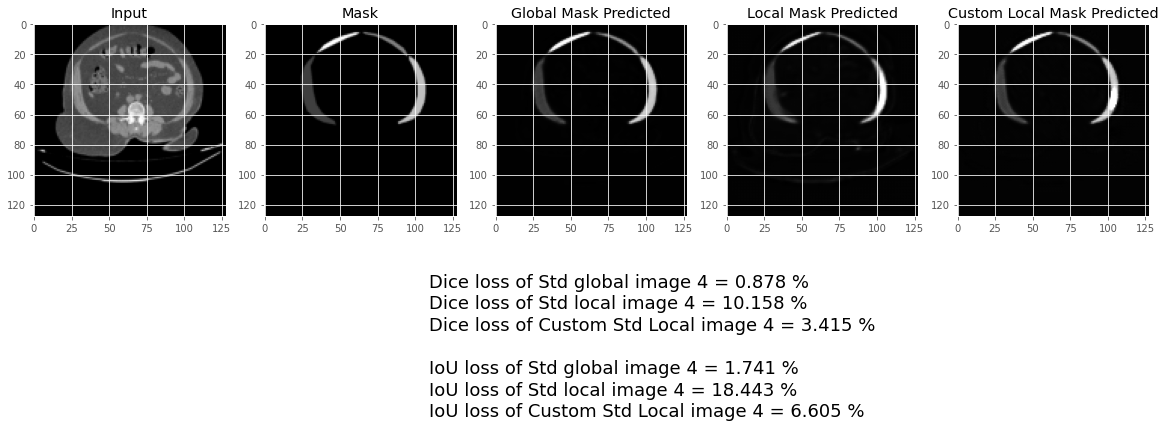

In [56]:
plot_sample_compare(X_std_train, y_std_train, preds_train_global_std, preds_train_local_std, preds_train_local_std_DLE,train_text)

						Validation 


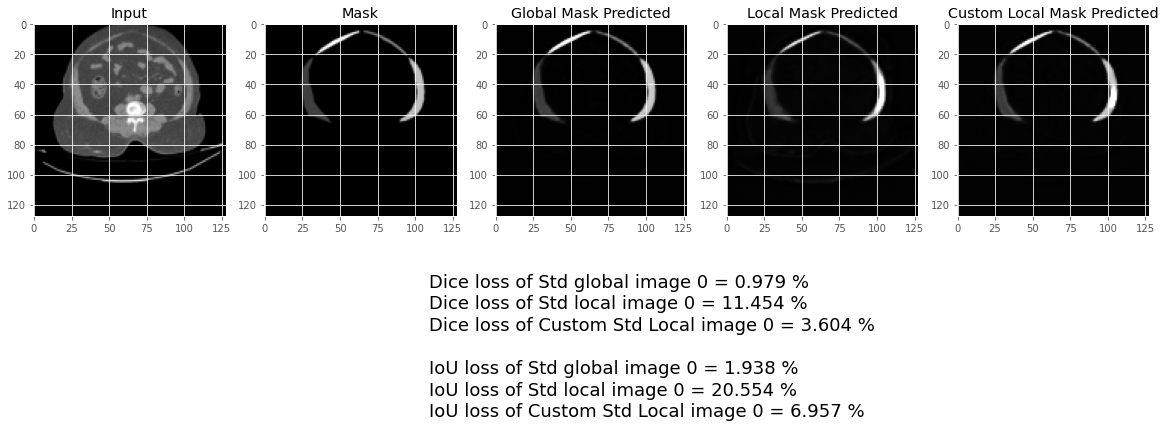

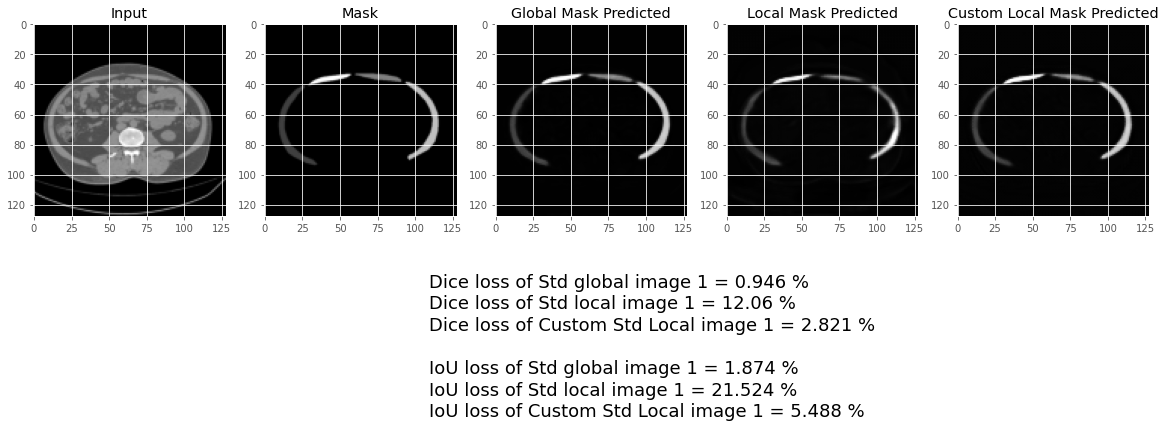

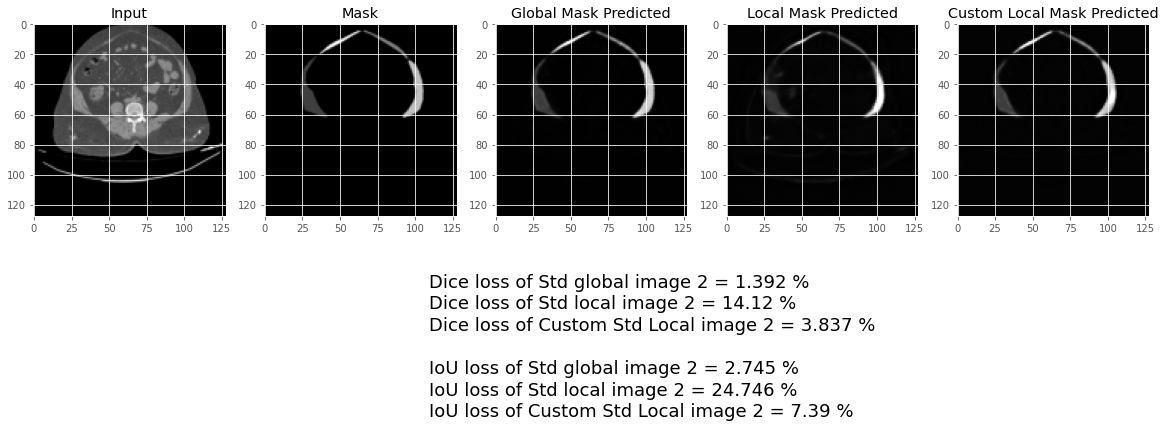

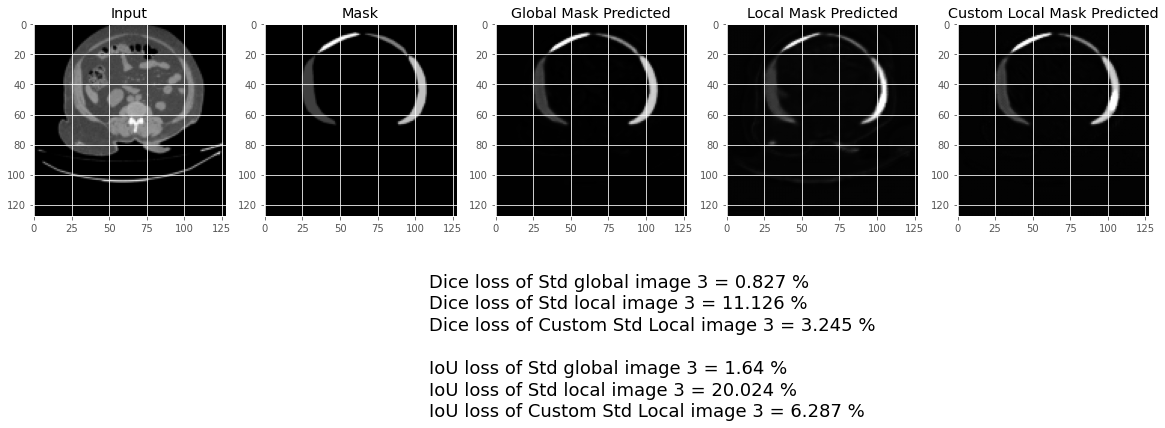

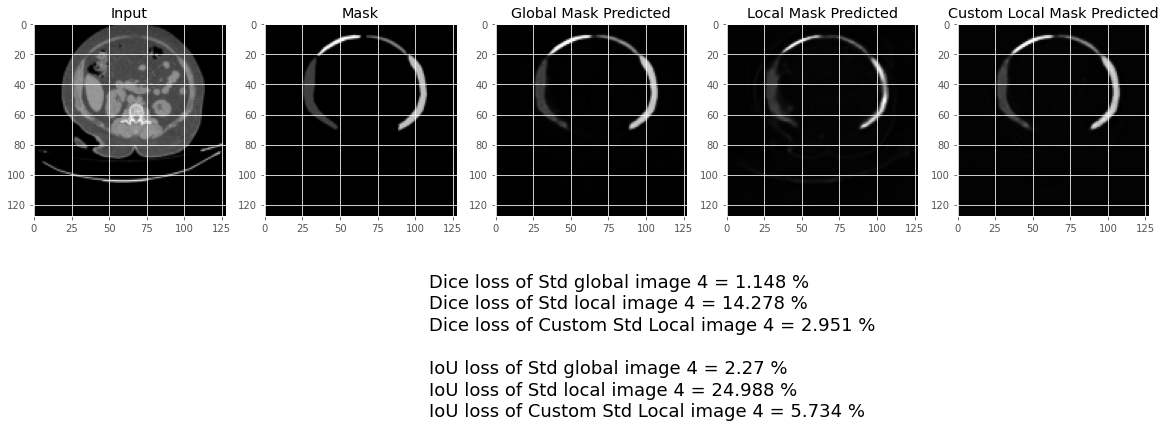

In [61]:
plot_sample_compare(X_std_valid, y_std_valid, preds_val_global_std, preds_val_local_std, preds_val_local_std_DLE, valid_text)

							Testing 


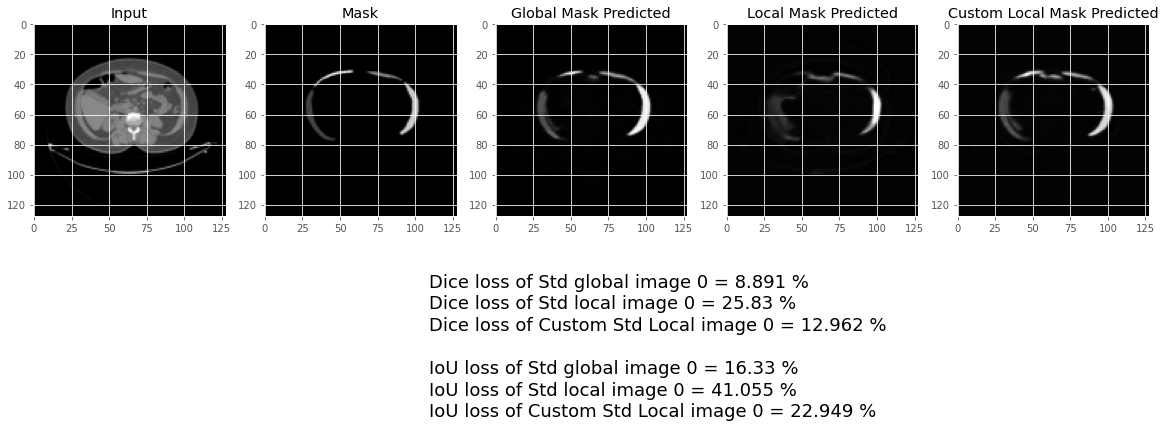

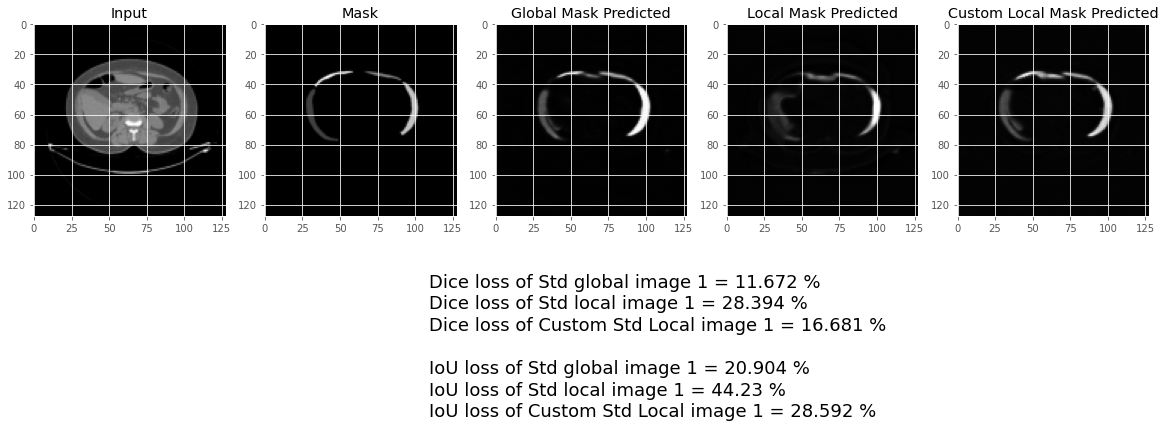

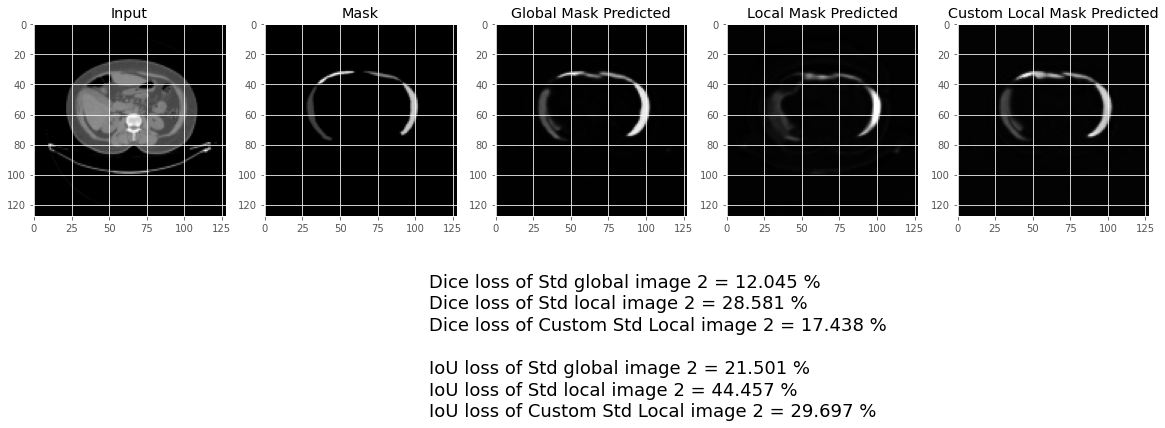

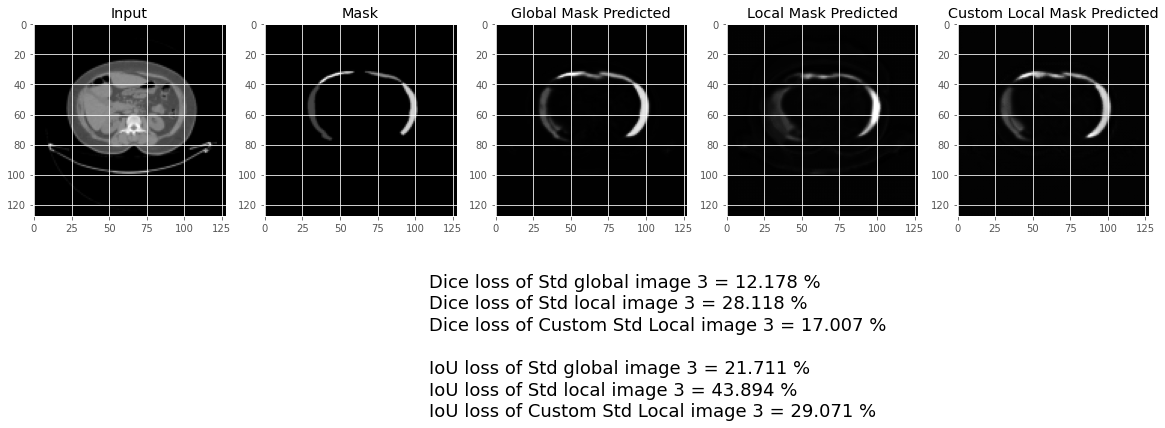

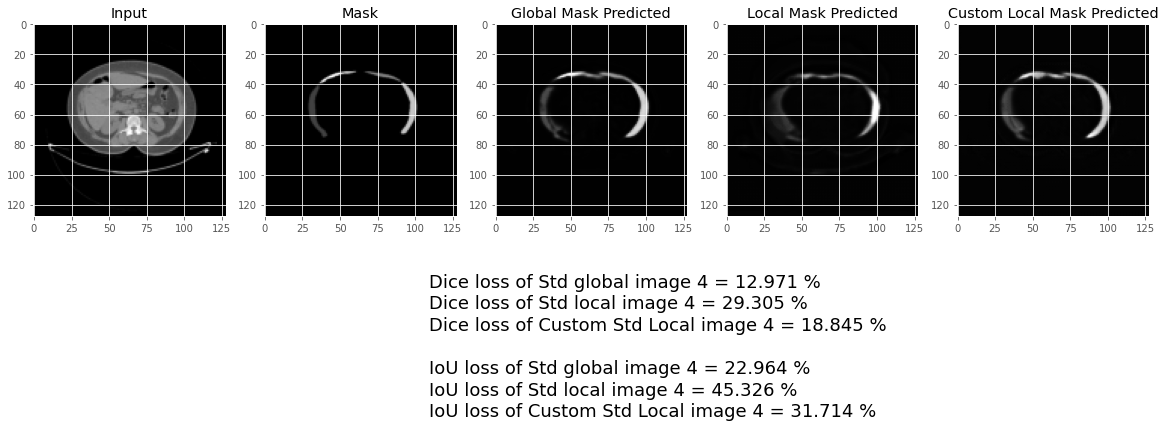

In [62]:
plot_sample_compare(X_std_test, y_std_test, preds_test_global_std, preds_test_local_std, preds_test_local_std_DLE, test_text, range_1)

Range 4

							Testing 


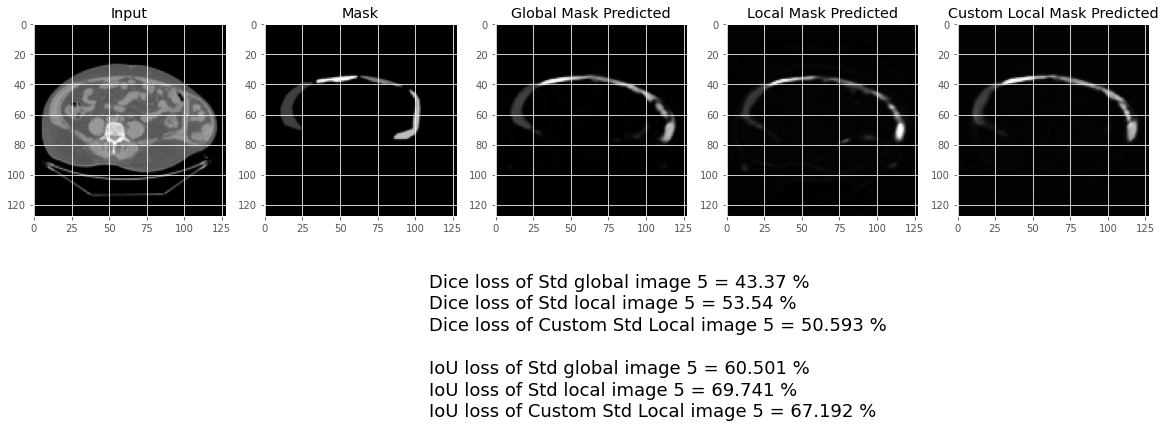

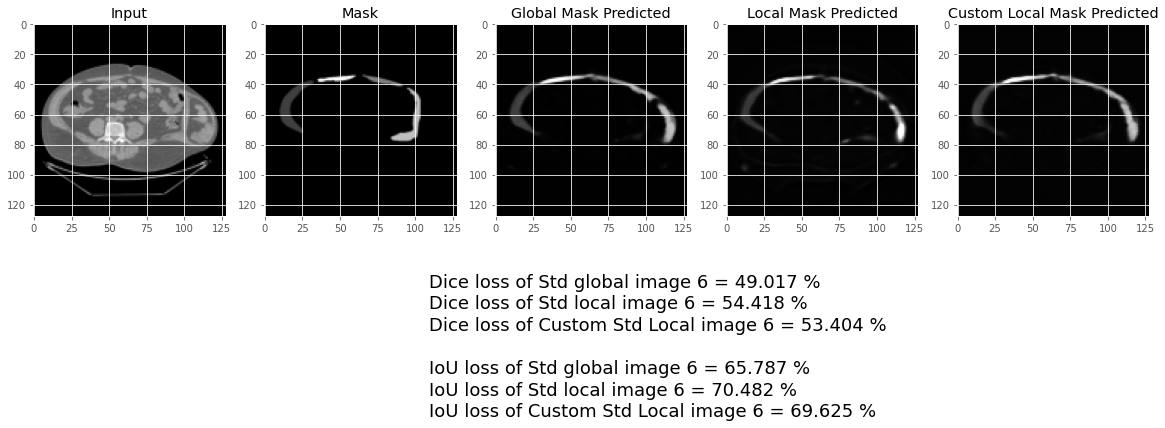

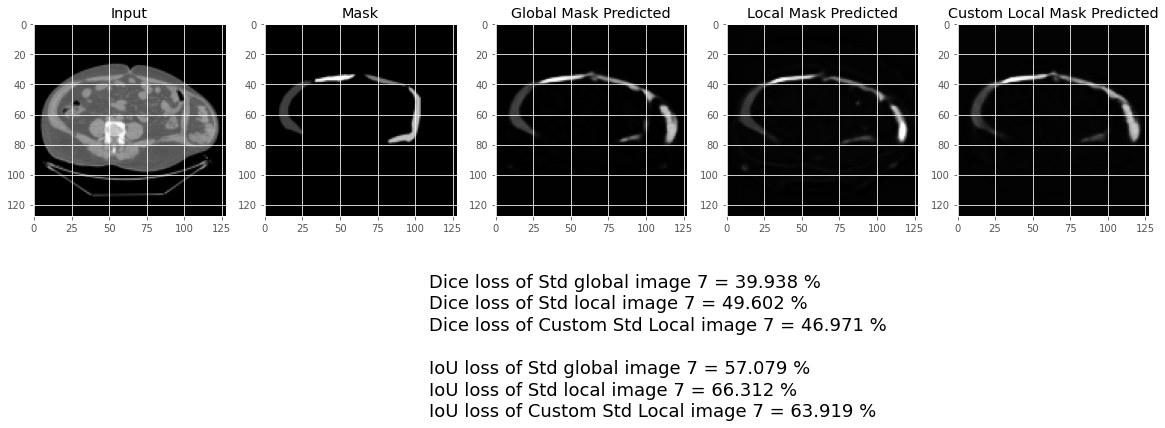

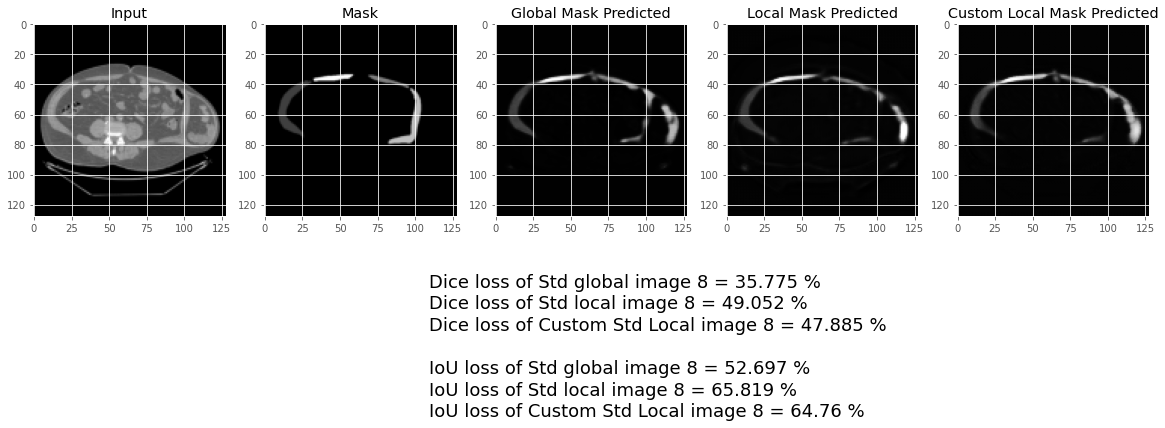

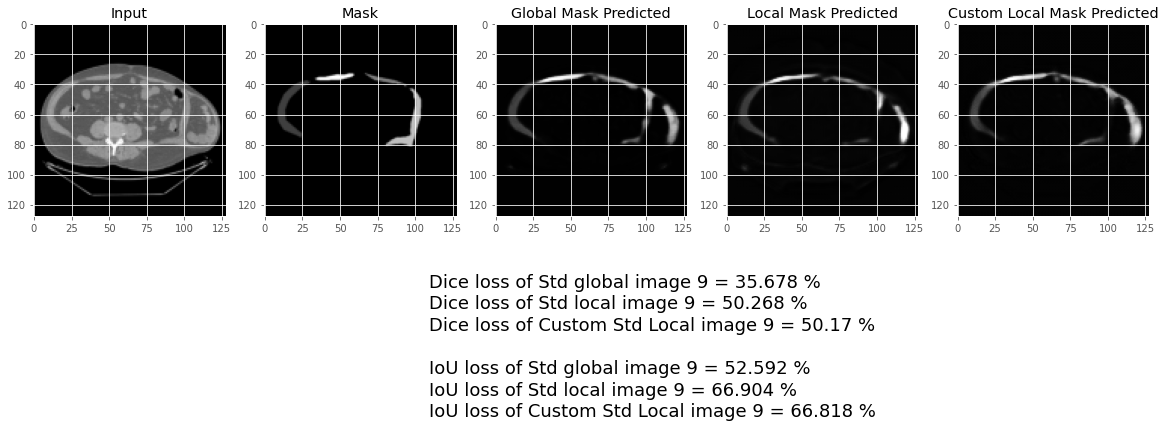

In [63]:
plot_sample_compare(X_std_test, y_std_test, preds_test_global_std, preds_test_local_std, preds_test_local_std_DLE, test_text, range_4)